<div class="alert alert-info">

<H1> Data Analysis Interview Challenge </H1>

<H2> Part 1 ‑ Exploratory data analysis </H2>

<H3> The *logins.json* file, located in the data folder, contains (simulated) timestamps of user logins in a particular
geographic location. 

Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them. </H3>
</div>


In [45]:
# imports
import pandas as pd
import numpy as np
# data viz imports
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
# time-series imports
from datetime import datetime
from pandas.tseries.offsets import CustomBusinessHour
from pandas.tseries.holiday import USFederalHolidayCalendar



<div class="alert alert-success">
<H3> Process time-series data into 15min chunks </H3>
</div>

In [2]:
# load data as a data frame
login_data = pd.read_json('data/logins.json')
# add a column to represent the number of logins during each time
login_data['login_count'] = np.ones(len(login_data), dtype= 'int')
# set the login time as a datetime index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))
# keep only the count and index
#logins = login_data[['login_count']]
# resample the index, so that time is represented in 15min chunks
logins_delta15 = login_data.resample('15Min').sum()

<div class="alert alert-success">
<H3> Visualize processed data </H3>
</div>

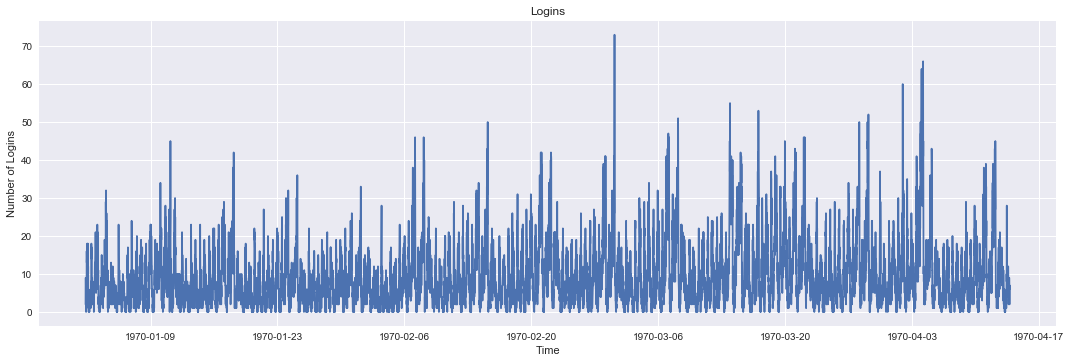

In [3]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
plt.plot(logins_delta15.index, logins_delta15.login_count)

<div class="alert alert-warning">
<strong>It does look like there is an underlying pattern in the data, but it is hard to see at this scale.  Therefore, I will do two things
    <ol>
        <li>Look at the entire time-series with larger chunksize</li>
        <li>Look at specific days separately</li>
        <li>Find the busiest time of day</li>
    </ol>
    </strong>
</div>
    

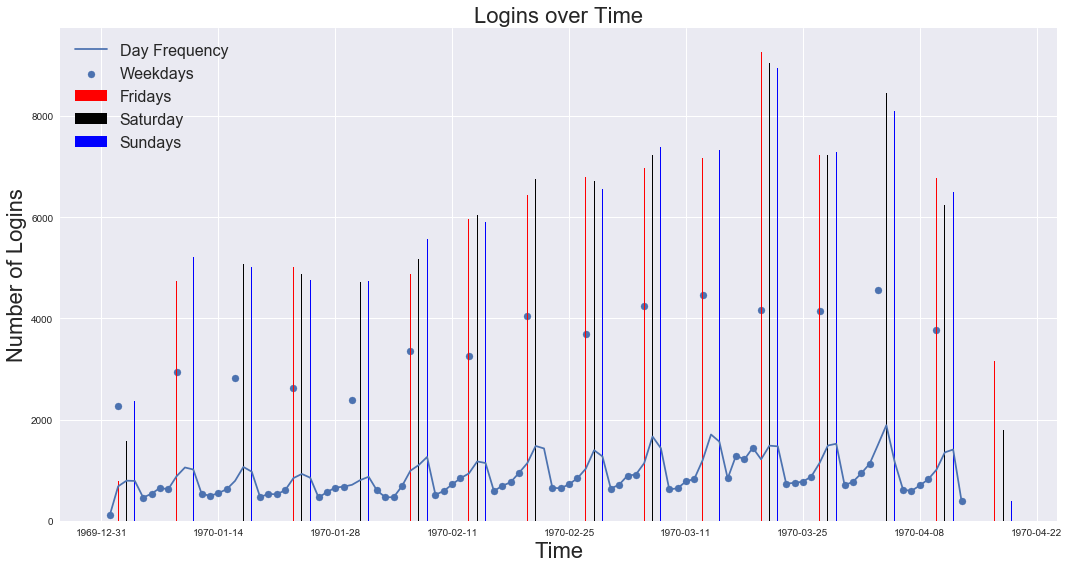

In [4]:
# bin data by the day
logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'R')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'B')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Day Frequency')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()


<div class="alert alert-warning">
<strong>The above graph makes it clear that Friday has the most logins, and that the weekends are busier than the weekdays.</strong>
</div>

In [7]:
# resample index hourly
daily_logins = login_data.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [67]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

In [69]:
avg_hourly_logins_df.head(2)

,hour,day_of_week,avg_num_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143


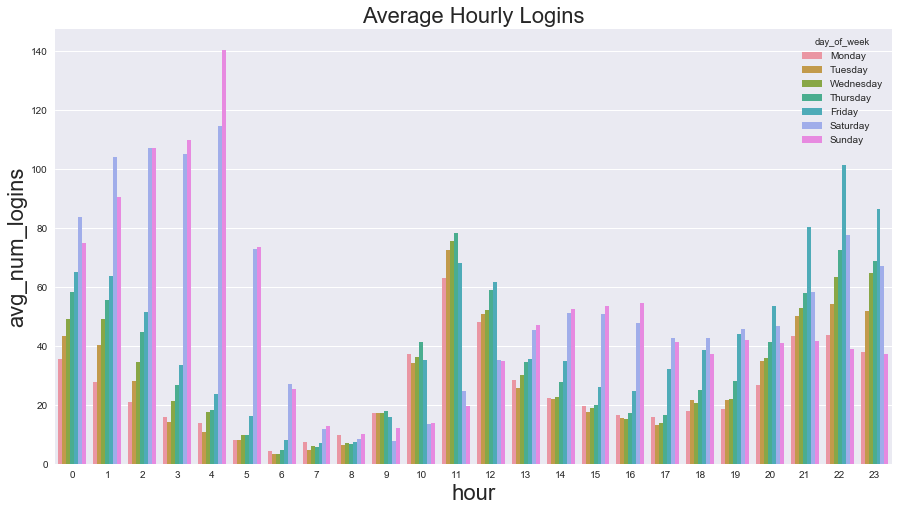

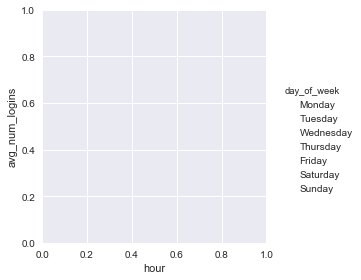

In [81]:
# plot average hourly use
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Hours', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Average Hourly Logins', fontsize = 22)

sns.factorplot(ax = ax, x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', hue='day_of_week')


<div class="alert alert-info">
<H2> Part 2 ‑ Experiment and metrics design </H2>

<H3> 
<p>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
</p>

<p>
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
    <ol>
        <li> What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</li>
        <li> Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
            <ul>
                <li> how you will implement the experiment</li>
                <li> what statistical test(s) you will conduct to verify the significance of the observation</li>
                <li> how you would interpret the results and provide recommendations to the city operations team along with any caveats.</li> 
</ul>
    </ol>
 </H3>
</div>